In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import torch
import pickle
import pandas as pd

In [2]:
def get_quantile(samples,q,dim=1):
    return torch.quantile(samples,q,dim=dim).cpu().numpy()
1

1

In [17]:
dataset = 'airquality' #choose 'healthcare' or 'airquality'
datafolder = 'pm25_outsample_20241226_102939_rearange with 2 layers'#'pretrained' # set the folder name
nsample = 100 # number of generated sample

path = './save/'+datafolder+'/generated_outputs_nsample' + str(nsample) + '.pk' 
with open(path, 'rb') as f:
    samples,all_target,all_evalpoint,all_observed,all_observed_time,scaler,mean_scaler = pickle.load( f)

all_target_np = all_target.cpu().numpy()
all_evalpoint_np = all_evalpoint.cpu().numpy()
all_observed_np = all_observed.cpu().numpy()
all_given_np = all_observed_np - all_evalpoint_np

K = samples.shape[-1] #feature
L = samples.shape[-2] #time length

if dataset == 'airquality':
    path = 'data/pm25/pm25_meanstd.pk'
    with open(path, 'rb') as f:
        train_mean,train_std = pickle.load(f)
    train_std_cuda = torch.from_numpy(train_std).cuda()
    train_mean_cuda = torch.from_numpy(train_mean).cuda()
    all_target_np=(all_target_np*train_std+train_mean)
    samples=(samples*train_std_cuda+train_mean_cuda)

In [18]:

qlist =[0.05,0.25,0.5,0.75,0.95]
quantiles_imp= []
for q in qlist:
    quantiles_imp.append(get_quantile(samples, q, dim=1)*(1-all_given_np) + all_target_np * all_given_np)

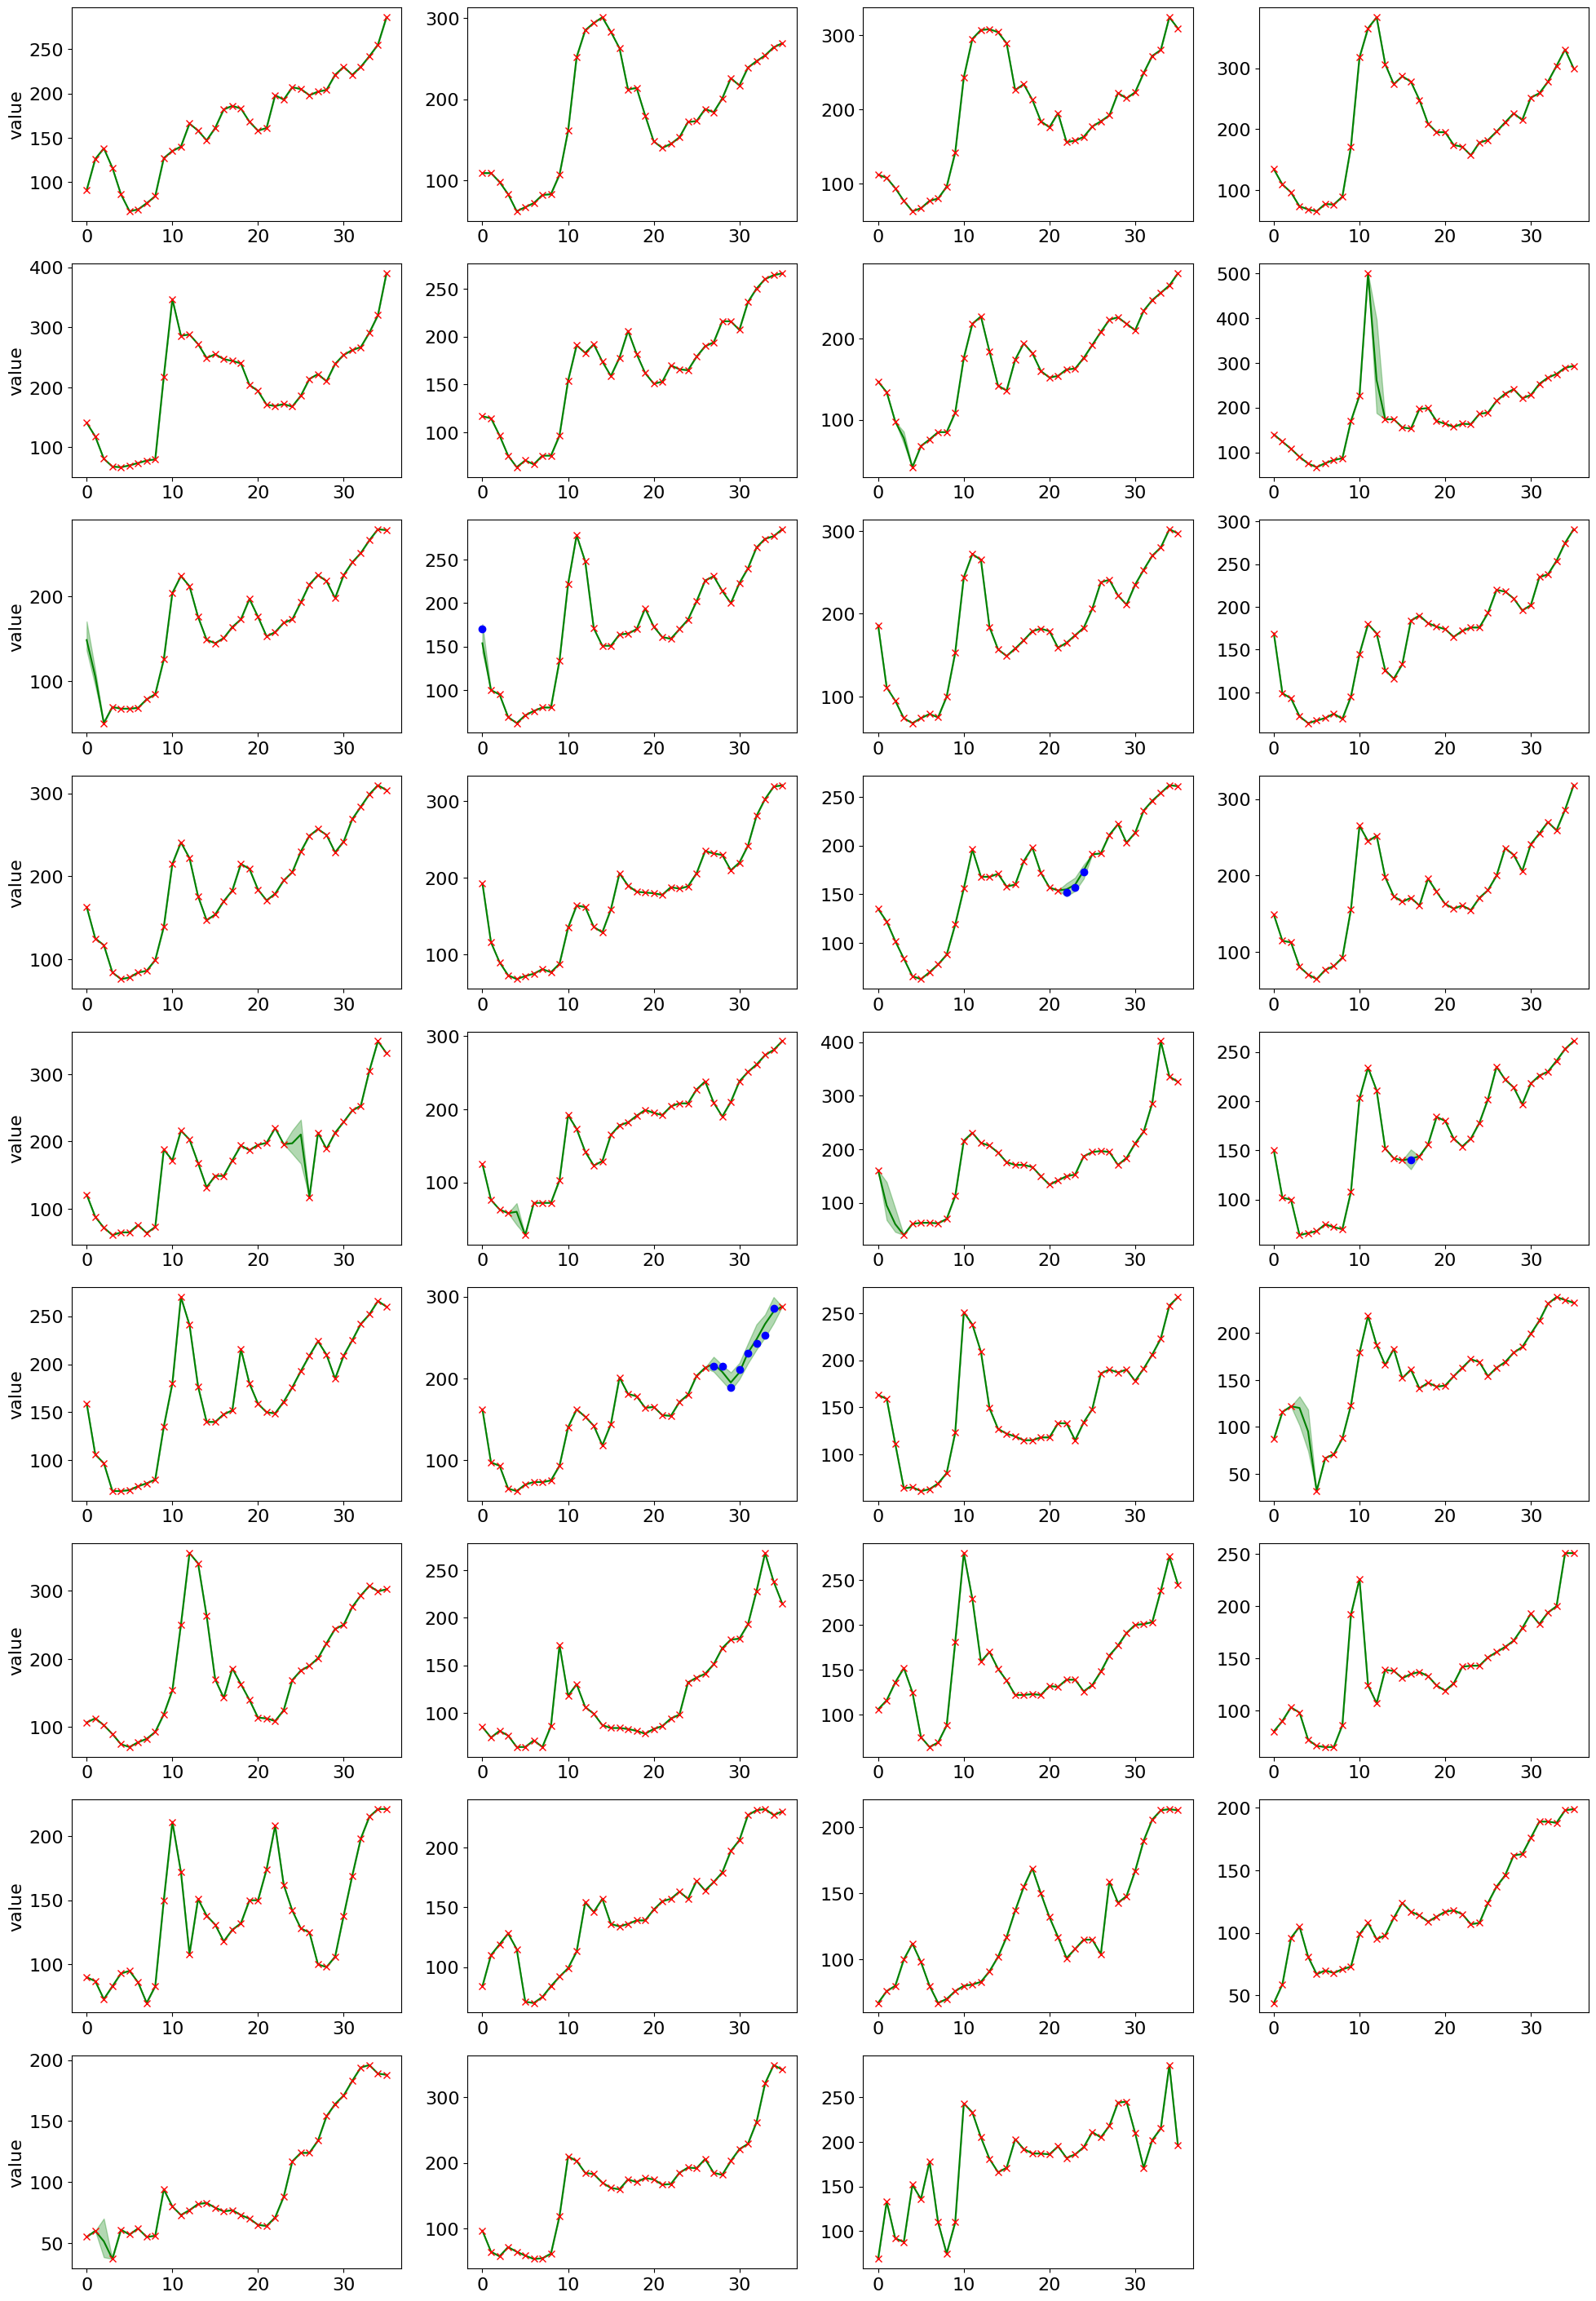

In [19]:
###healthcare###
dataind = 3 #change to visualize a different time-series sample

plt.rcParams["font.size"] = 16
fig, axes = plt.subplots(nrows=9, ncols=4,figsize=(24.0, 36.0))
fig.delaxes(axes[-1][-1])

for k in range(K):
    df = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k], "y":all_evalpoint_np[dataind,:,k]})
    df = df[df.y != 0]
    df2 = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k], "y":all_given_np[dataind,:,k]})
    df2 = df2[df2.y != 0]
    row = k // 4
    col = k % 4
    axes[row][col].plot(range(0,L), quantiles_imp[2][dataind,:,k], color = 'g',linestyle='solid',label='CSDI')
    axes[row][col].fill_between(range(0,L), quantiles_imp[0][dataind,:,k],quantiles_imp[4][dataind,:,k],
                    color='g', alpha=0.3)
    axes[row][col].plot(df.x,df.val, color = 'b',marker = 'o', linestyle='None')
    axes[row][col].plot(df2.x,df2.val, color = 'r',marker = 'x', linestyle='None')
    if col == 0:
        plt.setp(axes[row, 0], ylabel='value')
    if row == -1:
        plt.setp(axes[-1, col], xlabel='time')


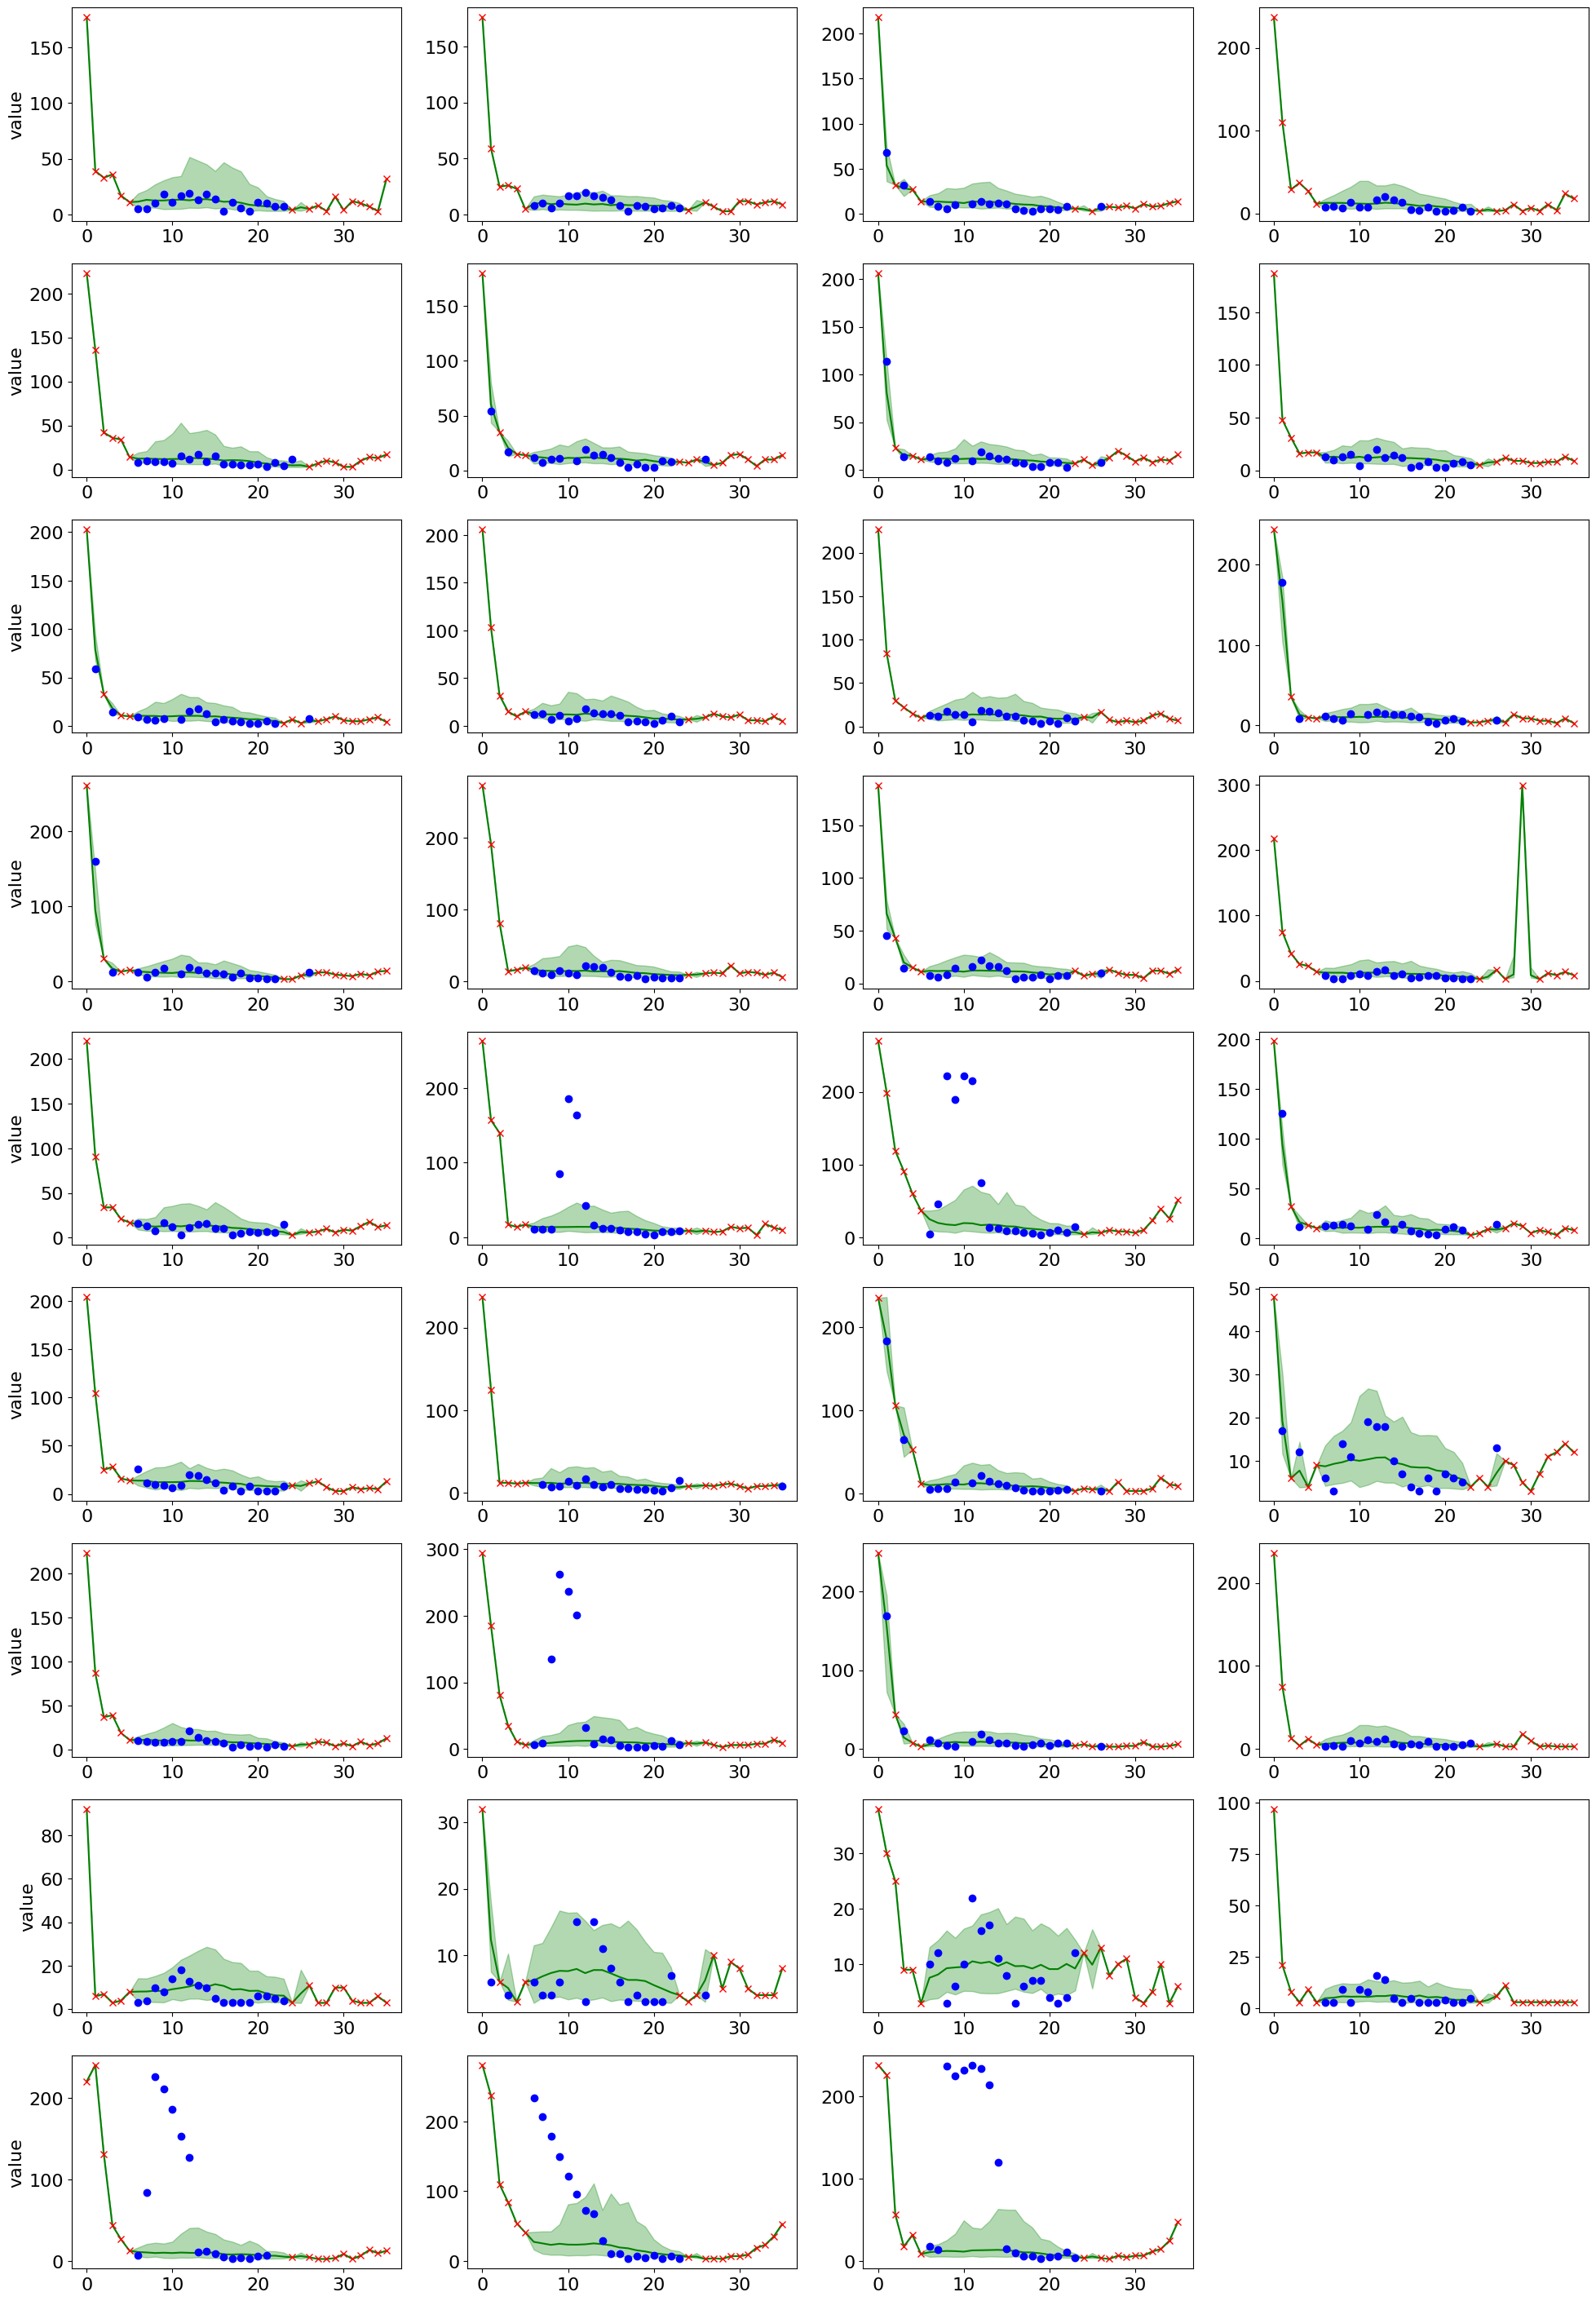

In [20]:
###airquality###
dataind = 5 #change to visualize a different sample

plt.rcParams["font.size"] = 16
fig, axes = plt.subplots(nrows=9, ncols=4,figsize=(24.0, 36.0))
fig.delaxes(axes[-1][-1])

for k in range(K):
    df = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k], "y":all_evalpoint_np[dataind,:,k]})
    df = df[df.y != 0]
    df2 = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k], "y":all_given_np[dataind,:,k]})
    df2 = df2[df2.y != 0]
    row = k // 4
    col = k % 4
    axes[row][col].plot(range(0,L), quantiles_imp[2][dataind,:,k], color = 'g',linestyle='solid',label='CSDI')
    axes[row][col].fill_between(range(0,L), quantiles_imp[0][dataind,:,k],quantiles_imp[4][dataind,:,k],
                    color='g', alpha=0.3)
    axes[row][col].plot(df.x,df.val, color = 'b',marker = 'o', linestyle='None')
    axes[row][col].plot(df2.x,df2.val, color = 'r',marker = 'x', linestyle='None')
    if col == 0:
        plt.setp(axes[row, 0], ylabel='value')
    if row == -1:
        plt.setp(axes[-1, col], xlabel='time')
# plt.savefig('prediction.png')

In [7]:
k=0
list_mae = []
for k in range(36):
    mask = all_evalpoint_np[:,:,k]!=0
    MAE = np.abs(all_target_np[:,:,k][mask] - quantiles_imp[2][:,:,k][mask]).mean()
    print(f'{k}: {(MAE-train_mean[k])/train_std[k]}')
    # su += (MAE-train_mean[k])/train_std[k]
    list_mae.append(MAE)

0: -1.0011277013241235
1: -0.9355573849607038
2: -1.034370063602652
3: -0.9715570485582836
4: -0.9283769721351658
5: -1.0010177988762903
6: -1.016924497234839
7: -1.02019193679406
8: -0.9926039174533817
9: -1.0143674565512277
10: -1.0633936272848572
11: -0.9619922037213576
12: -0.9825044268426116
13: -0.9461506613325779
14: -1.0370776836361308
15: -1.002770298190259
16: -0.9448282519622099
17: -0.9841136048357351
18: -0.9490583669479743
19: -1.0067595549140733
20: -1.0341523522067546
21: -0.9851648118132251
22: -0.9740383539893785
23: -0.905781524048255
24: -0.9485095914046271
25: 4.2383332339805
26: -0.949536045439618
27: -0.8611704384300131
28: -0.9062838295426439
29: -0.8488462271887885
30: -0.8723806441783851
31: -0.7899768467264882
32: 4.134981189634011
33: 3.9976011538128504
34: 4.520042220877055
35: 4.174049568671473


In [8]:
mask = all_given_np[:,:,k]!=0
np.mean((all_target_np[:,:,k][mask] - quantiles_imp[2][:,:,k][mask])**2)

0.0

array([14,  7,  5, 12,  1,  8,  9,  0, 20, 10, 11, 21,  6,  2, 23, 29, 24,
       26, 30, 13, 19, 15, 22, 27, 28,  3, 31, 17, 16,  4, 18, 32, 25, 34,
       33, 35])

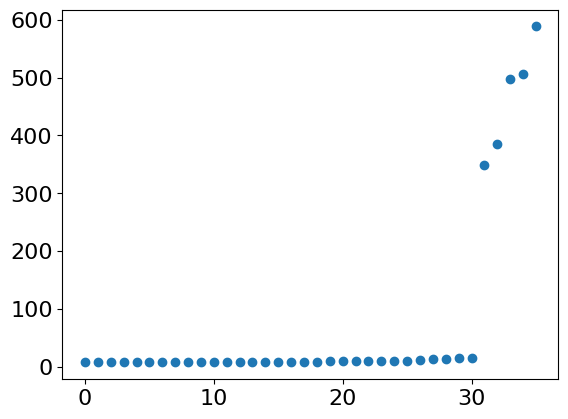

In [9]:
plt.plot(np.sort(list_mae), 'o')

a = np.argsort(list_mae)
a

In [10]:
list_mae

[8.242469047902699,
 8.133379112332651,
 8.464400254681273,
 10.077662095576605,
 14.647068532817277,
 7.851774499877803,
 8.451070573934315,
 7.619332900236367,
 8.155668470048711,
 8.217544136966135,
 8.340578813260114,
 8.370437236913338,
 7.987205142217792,
 9.20451395093442,
 7.362890740446673,
 9.31587175829545,
 13.145344661169736,
 12.950754057159267,
 14.902695258388512,
 9.221970554602981,
 8.321456062081296,
 8.421412673791707,
 9.512358046409702,
 8.504469645390314,
 8.568092000629582,
 384.8271747239043,
 8.59530319483488,
 9.558017255685316,
 9.637369093303835,
 8.561867416404649,
 8.773055038202285,
 11.579599011376395,
 349.55444476085137,
 506.25904534173463,
 498.2217284884181,
 588.4699230687168]

In [11]:
np.random.choice(36, 10, replace=False)

array([26,  7, 27,  6, 23,  5, 16, 19, 17,  0])

In [12]:
mm = np.random.choice(36, 10, replace=False)
all_evalpoint_np = np.zeros([82,36,36])
all_evalpoint_np[:,mm,:] = 1

8.081127978930624


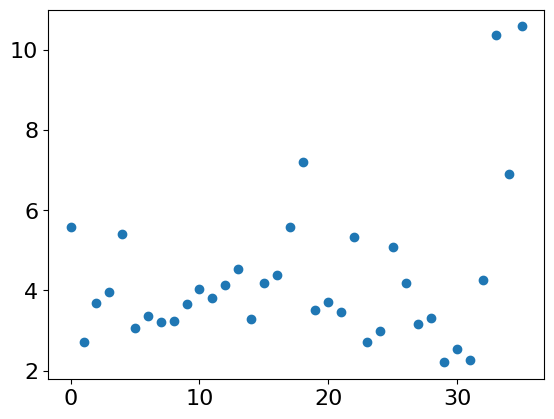

In [21]:
ddd = samples.cpu().numpy().transpose(1,0,2,3)*all_evalpoint_np
ddd[0,5,0,:] = 170



print(np.std(ddd,axis=0)[5,20,0])
np.std(ddd[:,5,20,0])


# ddd.shape
plt.plot(np.mean(np.std(ddd, axis=0), axis=1)[5],'o')

In [22]:
np.mean(np.std(ddd, axis=0))

1.8198205178264326

In [23]:
std_1 = np.mean(np.std(ddd[:,:,:,[2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]], axis=0))
std_2 = np.mean(np.std(ddd[:,:,:,[0,  1, 22, 23, 24, 26, 27, 28, 29, 30, 31]], axis=0))
std_3 = np.mean(np.std(ddd[:,:,:,[25, 32, 33, 34, 35]], axis=0))

print(std_1, std_2, std_3)

1.657453392772185 1.6553828930142558 2.831051792630213
